In [35]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [5]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [6]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [199]
Gradients: [np.float64(-4.000000000000012)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [199]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [199]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-3.4142135623691776)]
Initial energy: -3.828427124746197
Optimizing energy with indices [199, 244]...
Starting point: [np.float64(0.39269908170011053), np.float64(0.0)]

Current energy: -4.626284539634968
(change of -0.7978574148887709)
Current ansatz: [199, 244]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999417225
(change of -1.3737154597822574)
Current ansatz: [199, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181076
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999998057456)]
Initial energy: -5.999999999417225
Optimizing energy with indices [199, 244, 79, 228]...
Starting point: [np.float64(9.855378907157579e-06), np.float64(0.7853981714335022), np.float64(0.7853981407341485), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.1231056250415055
(change of -0.12310562562428018)
Current ansatz: [199, 244, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200501865
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.48507104824933)]
Initial energy: -6.1231056250415055
Optimizing energy with indices [199, 244, 79, 228, 210]...
Starting point: [np.float64(9.693301544538512e-06), np.float64(0.7853983074095231), np.float64(0.7853977639810573), np.float64(0.12248927961503872), np.float64(0.0)]

Current energy: -6.327276154271411
(change of -0.20417052922990564)
Current ansatz: [199, 244, 79, 228, 210]
Performing final convergence check...
Total gradient norm: 6.240962748730078

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.917526200501865 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429297)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 210]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.2041705292020577)
Current ansatz: [241, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531791
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894929267348776)]
Initial energy: -6.327276154819705
Optimizing energy with indices [241, 79, 225, 210, 147]...
Starting point: [np.float64(-0.7853981607743267), np.float64(0.7853981678304174), np.float64(-0.163570197408367), np.float64(0.16356963668287403), np.float64(0.0)]

Current energy: -6.464101615008459
(change of -0.13682546018875374)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-1.9999999999522045)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 201]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625548017
(change of -0.12310562561849903)
Current ansatz: [228, 79, 201]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917506431665617
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.4850600293890643)]
Initial energy: -6.123105625548017
Optimizing energy with indices [228, 79, 201, 228]...
Starting point: [np.float64(-0.7853977521525508), np.float64(0.7853977933716614), np.float64(0.1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.2409625787176335
Operator(s) added to ansatz: [141]
Gradients: [np.float64(2.089492926747546)]
Initial energy: -6.327276154816648
Optimizing energy with indices [228, 79, 201, 228, 141]...
Starting point: [np.float64(-0.7853977521525458), np.float64(0.7853988798879336), np.float64(0.16357019699115416), np.float64(0.16356963656316684), np.float64(0.0)]

Current energy: -6.464101615068996
(change of -0.1368254602523482)
Current ansatz: [228, 79, 201, 228, 141]
Performing final convergence check...
Total gradient norm: 0.0001373491823016229

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409625787176335 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964040371926
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916447538887)]
Initial energy: -6.32727615481998
Optimizing energy with indices [244, 26, 228, 210, 198]...
Starting point: [np.float64(0.785398156811469), np.float64(0.785398154431449), np.float64(0.16357028642350993), np.float64(0.16356997171157828), np.float64(0.0)]

Current energy: -6.46410161505858
(change of -0.1368254602386001)
Current ansatz: [24

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0000000000000044)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 210]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [244, 74, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200183383
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071047842222)]
Initial energy: -6.123105625617642
Optimizing energy with indices [244, 74, 210, 225]...
Starting point: [np.float64(0.785398163396527), np.float64(-0.7853981633984565), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 147]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998185
(change of -1.7639320224983894)
Current ansatz: [228, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140567
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.99999999999442)]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 225]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.123105625610642
(change of -0.12310562561245764)
Current ansatz: [228, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955728
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485068789868941)]
Initial energy: -6.123105625610642
Optimizing energy with indices [228, 74, 225, 147]...
Starting point: [np.float64(-0.7853983869831797), np.float64(-0.7853991695302367), np.float64(-0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.4850710474292033)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 45]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240964044456069
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.089491641167056)]
Initial energy: -6.327276154819981
Optimizing energy with indices [244, 79, 228, 45, 108]...
Starting point: [np.float64(0.7853981613321709), np.float64(0.7853981598792701), np.float64(0.16357028667248125), np.float64(0.1635699726489259), np.float64(0.0)]

Current energy: -6.464101615062932
(change of -0.1368254602429504)
Current ansatz: [244, 79, 228, 45, 108]
Performing final convergence check...
Total gradient norm: 0.00014174702751517564

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044456069 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.000000000000004

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619964306
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071047541058)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 210, 225]...
Starting point: [np.float64(0.7853981908695737), np.float64(0.7853981903042655), np.float64(0.12248927937223411), np.float64(0.0)]

Current energy: -6.327276154819498
(change of -0.2041705292018472)
Current ansatz: [244, 79, 210, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580347369
Operator(s) added to ansatz: [54]
Gradients: [np.float64(-2.0894929270476665)]
Initial energy: -6.327276154819498
Optimizing energy with indices [244, 79, 210, 225, 54]...
Starting point: [np.float64(0.7853982318859356), np.float64(0.7853984111666573), np.float64(0.16357019742529944), np.float64(-0.1635696366118327), np.float64(0.0)]

Current energy: -6.464101614606746
(change of -0.13682545978724825)
Current ansatz: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001361285843518749

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044667907 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 79]...
Starting point: [np.float64(-0.5535743588970451), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620177583
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071048468284)]
Initial energy: -6.123105625562494
Optimizing energy with indices [228, 79, 225, 198]...
Starting point: [np.float64(-0.7853947065772614), np.float64(0.7853985308794381), np.float64(-0.12248927961669928), np.float64(0.0)]

Current energy: -6.327276154764998
(change of -0.20417052920250356)
Current ansatz: [228, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069151
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089491643863277)]
Initial energy: -6.327276154764998
Optimizing energy with indices [228, 79, 225, 198, 210]...
Starting point: [np.float64(-0.785394706577125), np.float64(0.7853982468601275), np.float64(-0.16357028648717148), np.float64(-0.16356997194354164), np.float64(0.0)]

Current energy: -6.4641016150180395
(change of -0.13682546025304188)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.763932022498393)
Current ansatz: [228, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897114057
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.999999999994421)]
Initial energy: -5.999999999998188
Optimizing energy with indices [228, 31, 228]...
Starting point: [np.float64(-0.7853985607314264), np.float64(-0.7853989420959467), np.float64(0.0)]

Current energy: -6.123105625610651
(change of -0.12310562561246297)
Current ansatz: [228, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955701
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868923)]
Initial energy: -6.123105625610651
Optimizing energy with indices [228, 31, 228, 210]...
Starting point: [np.float64(-0.7853983869831787), np.float64(-0.7853991695302327), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200768378
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.485071048168266)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 31, 201, 216]...
Starting point: [np.float64(-0.7853981633974474), np.float64(-0.7853981633974486), np.float64(0.12248927953385899), np.float64(0.0)]

Current energy: -6.327276154819703
(change of -0.20417052920206125)
Current ansatz: [241, 31, 201, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531911
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.089492926734877)]
Initial energy: -6.327276154819703
Optimizing energy with indices [241, 31, 201, 216, 228]...
Starting point: [np.float64(-0.7853981633974365), np.float64(-0.7853981633975148), np.float64(0.16357019740839474), np.float64(-0.16356963668288166), np.float64(0.0)]

Current energy: -6.464101615135381
(change of -0.136825460315678)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850687898689596)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 147]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.12248869758311001), np.float64(0.0)]

Current energy: -6.32727615481636
(change of -0.20417052920571344)
Current ansatz: [225, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962567144736
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.089492948558589)]
Initial energy: -6.32727615481636
Optimizing energy with indices [225, 79, 228, 147, 45]...
Starting point: [np.float64(0.785398438850203), np.float64(0.7853991591701985), np.float64(0.16357019849079582), np.float64(-0.1635696317029856), np.float64(0.0)]

Current energy: -6.464101614774235
(change of -0.13682545995787532)
Current ansatz: [

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614734
(change of -1.4968210859797662)
Current ansatz: [199, 241, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91753072080658
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.4850735673672744)]
Initial energy: -6.123105625614734
Optimizing energy with indices [199, 241, 79, 228]...
Starting point: [np.float64(0.12248992871667236), np.float64(-0.7853981486095067), np.float64(0.7853981593384867), np.float64(0.0)]

Current energy: -6.327276154820054
(change of -0.20417052920531997)
Current ansatz: [199, 241, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963782409839
Operator(s) added to ansatz: [39]
Gradients: [np.float64(2.0894918716764543)]
Initial energy: -6.327276154820054
Optimizing energy with indices [199, 241, 79, 228, 39]...
Starting point: [np.float64(0.1635702707681713)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 108]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.3272761548197085
(change of -0.20417052920206125)
Current ansatz: [244, 26, 228, 108]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409625805316296
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.0894929267351734)]
Initial energy: -6.3272761548197085
Optimizing energy with indices [244, 26, 228, 108, 45]...
Starting point: [np.float64(0.7853981504601909), np.float64(0.7853981591821104), np.float64(0.1635701974083824), np.float64(-0.1635696366828072), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101614823195
(change of -0.13682546000348683)
Current ansatz: [244, 26, 228, 108, 45]
Performing final convergence check...
Total gradient norm: 0.00027118918560717044

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409625805316296 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.00000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.0000000000000044)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 201]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763838)
Current ansatz: [244, 79, 201]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768387
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.48507104816827)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 79, 201, 216]...
Starting point: [np.float64(0.7853981633974513), np.float64(0.7853981633974504), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441738
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474288698)]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 147]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12248927934332132), np.float64(0.0)]

Current energy: -6.327276154819711
(change of -0.2041705292020728)
Current ansatz: [241, 26, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531794
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.08949292673488)]
Initial energy: -6.327276154819711
Optimizing energy with indices [241, 26, 228, 147, 210]...
Starting point: [np.float64(-0.7853981638732243), np.float64(0.7853981637530733), np.float64(0.16357019740836667), np.float64(-0.16356963668287391), np.float64(0.0)]

Current energy: -6.464101615135374
(change of -0.1368254603156629)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999475316
(change of -1.373715459840347)
Current ansatz: [211, 228, 74]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958972842295
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999973729325)]
Initial energy: -5.999999999475316
Optimizing energy with indices [211, 228, 74, 228]...
Starting point: [np.float64(-3.9073961684063536e-07), np.float64(-0.7854096986526888), np.float64(-0.7854095118369421), np.float64(0.0)]

Current energy: -6.123105622932155
(change of -0.12310562345683973)
Current ansatz: [211, 228, 74, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917497199235557
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850548682741262)]
Initial energy: -6.123105622932155
Optimizing energy with indices [211, 228, 74, 228, 147]...
Starting point: [np.float64(1.8101457354

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 120]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013640859207318388

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964043040389 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200767302
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710481676668)]
Initial energy: -6.123105625617644
Optimizing energy with indices [241, 79, 216, 201]...
Starting point: [np.float64(-0.7853981624814353), np.float64(0.7853981626766198), np.float64(-0.12248927953370452), np.float64(0.0)]

Current energy: -6.327276154819713
(change of -0.20417052920206924)
Current ansatz: [241, 79, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531864
Operator(s) added to ansatz: [30]
Gradients: [np.float64(2.0894929267349687)]
Initial energy: -6.327276154819713
Optimizing energy with indices [241, 79, 216, 201, 30]...
Starting point: [np.float64(-0.7853981639998062), np.float64(0.7853981647930687), np.float64(-0.16357019740839962), np.float64(0.16356963668286162), np.float64(0.0)]

Current energy: -6.464101615134642
(change of -0.13682546031492926)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 108]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072751
(change of -0.13682546025276388)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001350560817700983

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 26]...
Starting point: [np.float64(-0.5535743588970451), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000193667)]
Initial energy: -5.999999999929516
Optimizing energy with indices [228, 26, 228]...
Starting point: [np.float64(-0.7853947065773501), np.float64(0.785399377726245), np.float64(0.0)]

Current energy: -6.1231056255624825
(change of -0.12310562563296656)
Current ansatz: [228, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775818
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.485071048441265)]
Initial energy: -6.1231056255624825
Optimizing energy with indices [228, 26, 228, 120]...
Starting point: [np.float64(-0.7853947065772612), np.float64(0.7853985308794263), np.float64(0.12248927961669973), np.float64(0.0)]

Current energy: -6.327276154760147
(change of -0.20417052919766476)
Current ansatz: [228, 26, 228, 120]

*** ADAPT-VQE Iteration 5 ***

Creating list of up t

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964040371926
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916447538887)]
Initial energy: -6.32727615481998
Optimizing energy with indices [244, 26, 228, 210, 147]...
Starting point: [np.float64(0.785398156811469), np.float64(0.785398154431449), np.float64(0.16357028642350993), np.float64(0.16356997171157828), np.float64(0.0)]

Current energy: -6.464101615058578
(change of -0.13682546023859743)
Current ansatz: [244, 26, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.0001435936123970028

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz: [244, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.0000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.9999999999999996)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 225]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [241, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.485071047429297)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 135]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955753
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850687898689525)]
Initial energy: -6.123105625610651
Optimizing energy with indices [225, 26, 225, 210]...
Starting point: [np.float64(0.7853983869831791), np.float64(0.7853991695302315), np.float64(-0.12248869758310756), np.float64(0.0)]

Current energy: -6.327276154816342
(change of -0.20417052920569123)
Current ansatz: [225, 26, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962567145994
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492948562477)]
Initial energy: -6.327276154816342
Optimizing energy with indices [225, 26, 225, 210, 198]...
Starting point: [np.float64(0.785398438857372), np.float64(0.785399159170187), np.float64(-0.16357019849086973), np.float64(0.16356963170328181), np.float64(0.0)]

Current energy: -6.464101615132133
(change of -0.1368254603157908)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0000000000000036)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 216]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617644
(change of -0.12310562561763838)
Current ansatz: [241, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200767302
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048167666)]
Initial energy: -6.123105625617644
Optimizing energy with indices [241, 79, 216, 225]...
Starting point: [np.float64(-0.7853981624814353), np.float64(0.7853981626766198), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0002805605397347146

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964115398415 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [225, 26]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955753
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850687898689525)]
Initial energy: -6.123105625610651
Optimizing energy with indices [225, 26, 225, 198]...
Starting point: [np.float64(0.7853983869831791), np.float64(0.7853991695302315), np.float64(-0.12248869758310756), np.float64(0.0)]

Current energy: -6.327276154816639
(change of -0.20417052920598788)
Current ansatz: [225, 26, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640564135405
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894916407332023)]
Initial energy: -6.327276154816639
Optimizing energy with indices [225, 26, 225, 198, 210]...
Starting point: [np.float64(0.7853984379181594), np.float64(0.7853991591701045), np.float64(-0.16357028929925463), np.float64(-0.16356997348665922), np.float64(0.0)]

Current energy: -6.464101615069485
(change of -0.13682546025284648)
Current

## Run ADAPT at larger size to get a sequence of circuits.

In [7]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [8]:
# Now go to the larger size.
new_l = 4 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 16
Got DMRG energy -2.76469e+01
Tiled pool has 228 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -14.999999999999936
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.000000000000002
Operator 1: 3.9999999999999853
Operator 2: -3.9999999999999782
Operator 3: 3.9999999999999756
Operator 4: -3.9999999999999787
Operator 5: 3.9999999999999822
Operator 6: -4.000000000000005
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 2: -3.4142135605665254
Operator 3: 3.9999999999999916
Operator 4: -3.999999999999991
Operator 5: 3.999999999999994
Operator 6: -3.414213562294366
Operator 8: -3.41421356229435
Operator 9: 3.999999999999986
Operator 10: -3.4142135529705055
Operator 11: -3.761030420434963e-08
Operator 12: -3.4142135529705073
Operator 14: 3.4142135605665214
Operator 15: -3.9999999999999916
Operator 16: 3.999999999999991
Operator 17: -3.999999999999994
Operator 18: 3.414213562294364
Operator 20: 3.4142135622943512
Operator 21: -3.999999999999986
Operator 22: 3.4142135529705047
Operator 23: 3.761030242799279e-08
Operator 24: 3.4142135529705104
Operator 25: -3.999999999999996
Operator 26: -3.9999999999999867
Operator 27: 3.414213560566546
Operator 29: 3.4142135605665254
Operator 30: 2.8284271211330525
Operator 31: 3.999999999999991
Operator 32: 3.999999999999994
Operator 33: 3.414213562294364
Operator 35: 3.41421356229435
Operator 36: 2.828427124588692
Operator 37: 3.4142135529705047
Operator 38: -3

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 2: -2.529170705436514
Operator 3: -2.3666952160993945e-08
Operator 4: -3.264585404811789
Operator 5: 3.9999999999999742
Operator 6: -3.414213562279753
Operator 8: -3.4142135622797376
Operator 9: 3.9999999999999614
Operator 10: -3.414213549483979
Operator 11: -5.155633076014965e-08
Operator 12: -3.4142135494839803
Operator 13: 4.5155491853283803e-07
Operator 14: 2.529170705436508
Operator 15: 2.366695213310798e-08
Operator 16: 3.2645854048117897
Operator 17: -3.9999999999999742
Operator 18: 3.4142135622797514
Operator 20: 3.4142135622797376
Operator 21: -3.9999999999999614
Operator 22: 3.414213549483977
Operator 23: 5.155633076014965e-08
Operator 24: 3.414213549483982
Operator 25: -3.9999999999999747
Operator 26: -3.9999999999999605
Operator 27: 3.264585300624709
Operator 28: -4.5155491853283803e-07
Operator 29: 2.799588057154765
Operator 30: -0.929994718981
Operator 31: 3.2645854048117884
Operator 32: 2.529170809623607
Operator 33: 3.4142135622797514
Operator 35: 3.41421356227

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -19.544229
         Iterations: 9
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -19.544229345431848
(change of -1.1240772673850188)
Current ansatz: [226, 222, 216, 218, 127]
On iteration 5.

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.183606811228171
Operator 1: 1.154981147310207e-07
Operator 2: -2.1202962873058975
Operator 3: 1.2978423194439492e-07
Operator 4: -1.8733788527664383
Operator 5: -1.2856058120950444e-07
Operator 6: -2.1202960927317984
Operator 7: -9.736750812605067e-08
Operator 8: -3.183606716043089
Operator 9: 3.999999999999999
Operator 10: -3.414213564114379
Operator 12: -3.4142135641143794
Operator 13: -1.1549811408365552e-07
Operator 14: 2.1202962873058917
Operator 15: -1.2978423156473956e-07
Operator 16: 1.8733788527664406
Operator 17: 1.2856058120950444e-07
Operator 18: 2.1202960927317958
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -20.699827
         Iterations: 11
         Function evaluations: 113
         Gradient evaluations: 100

Current energy: -20.69982735349857
(change of -1.1555980080667219)
Current ansatz: [226, 222, 216, 218, 127, 131]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.163661536716035
Operator 1: -1.1056976461554988e-08
Operator 2: -2.0252068696879135
Operator 3: 2.3781979003400706e-08
Operator 4: -1.6072091229302434
Operator 6: -1.4913275827210009
Operator 8: -1.6072091171768776
Operator 10: -2.0252068556677396
Operator 11: -2.0613079243503307e-08
Operator 12: -3.163661531253521
Operator 13: 1.1056976584263362e-08
Operator 14: 2.0252068696879073
Operator 15: -2.3781977679467543e-08
Operator 16: 1.607209122930244
Operator 18: 1.4913275827209973
Operator 20: 1.6072091171768779
Operator 22: 2.0252068556677374
Operator 23: 2.061307924350330

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -22.337190
         Iterations: 14
         Function evaluations: 59
         Gradient evaluations: 47

Current energy: -22.33719022813699
(change of -1.63736287463842)
Current ansatz: [226, 222, 216, 218, 127, 131, 186]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.3275485480752415
Operator 1: 1.0156699241339909e-08
Operator 2: -0.548978342699758
Operator 4: -0.7822533472761344
Operator 5: -1.1757417308757933e-08
Operator 6: -1.0487121197272435
Operator 8: -1.396164029586179
Operator 10: -1.9459060085093056
Operator 11: 1.1149094092388623e-08
Operator 12: -3.146705008443441
Operator 13: -1.0156699243370292e-08
Operator 14: 0.5489783426997488
Operator 16: 0.7822533472761378
Operator 17: 1.1757417308757933e-08
Operator 18: 1.0487121197272395
Operator 20: 1.3961640295861804
Operator 22: 1.9459060085093034
Operator 23: -1.11490869869612

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.000000
         Iterations: 15
         Function evaluations: 62
         Gradient evaluations: 50

Current energy: -23.99999999249374
(change of -1.6628097643567514)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.00012996480866818427
Operator 1: -5.832739221547481e-06
Operator 2: 0.00020858824689173243
Operator 3: -3.5198700652912088e-06
Operator 4: 0.0002778590764155995
Operator 5: -7.35086878172998e-06
Operator 6: 0.0003362591684300097
Operator 7: -2.569782740261624e-06
Operator 8: 0.0003847386112198853
Operator 9: -8.397945371737308e-06
Operator 10: 0.000422250329300003
Operator 11: -3.9731915231211445e-06
Operator 12: 0.0004473909150232158
Operator 13: 5.83273922162185e-06
Operator 14: -0.00020858824690064015
Operator 15: 3.5198700652912088e-06
Operator 16: -0.00027785907

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.123106
         Iterations: 14
         Function evaluations: 52
         Gradient evaluations: 42

Current energy: -24.123105615011873
(change of -0.12310562251813195)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.00017962374859394607
Operator 1: 1.5041946690073014e-05
Operator 2: 0.0002798584507295256
Operator 3: 1.3375687823160546e-05
Operator 4: 0.00040851078898918264
Operator 5: -2.6954097663537874e-05
Operator 6: 0.0005235847218789123
Operator 7: 2.5081285499922216e-05
Operator 8: 0.0006367858517360665
Operator 9: -8.671005046095021e-05
Operator 10: 0.00042582674290271246
Operator 11: 6.359324514759734e-06
Operator 12: 0.0005883112819168312
Operator 13: -1.5041946690936572e-05
Operator 14: -0.00027985845073863746
Operator 15: -1.3375687823160546e-05
Operator 16: -

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.327276
         Iterations: 16
         Function evaluations: 72
         Gradient evaluations: 62

Current energy: -24.327276154821412
(change of -0.2041705398095388)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92]
On iteration 10.

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.0970535857093982e-07
Operator 1: 2.5164285528684092e-08
Operator 2: -2.7715082604867697e-07
Operator 3: 2.7499377192041763e-08
Operator 4: -2.9193265441151983e-07
Operator 5: 5.1350400845493275e-08
Operator 6: -2.2786473933197653e-07
Operator 7: 1.4733956609605937e-08
Operator 8: -9.771254470618623e-08
Operator 9: -7.084139409595113e-08
Operator 11: 2.7162404325764555e-08
Operator 12: -1.1223160623075046e-08
Operator 13: -2.5164286235225696e-08
Operator 14: 2.7715081678367315e-07
Operator 15: -2.749937777490885e-08
Operator 16: 2.91932656687477e-07
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.464102
         Iterations: 16
         Function evaluations: 69
         Gradient evaluations: 58

Current energy: -24.464101615137807
(change of -0.13682546031639475)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.640233554645482e-08
Operator 1: -7.418106279057617e-08
Operator 2: 2.6866404623985515e-08
Operator 3: 2.7860291379466766e-08
Operator 4: -1.8990315736600035e-08
Operator 5: 1.6039097351206565e-08
Operator 6: -2.0947675909835675e-08
Operator 8: -1.055277467105354e-08
Operator 9: 1.1048082140764637e-08
Operator 11: -2.0043680160064525e-08
Operator 12: 2.108511709675298e-08
Operator 13: 7.418106279057617e-08
Operator 14: -2.6866413415363725e-08
Operator 15: -2.7860291379466766e-08
Operator 16: 1.899031831786857e-08
Operator 17: -1.6039096463028148e-08


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.587207
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 32

Current energy: -24.58720724075537
(change of -0.123105625617562)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.2407590283016018e-07
Operator 1: -3.9034132062743003e-07
Operator 2: 9.783725106460314e-08
Operator 3: 1.171360293761304e-07
Operator 4: -2.0619687984835282e-07
Operator 5: 2.470368869854882e-07
Operator 6: -1.8779057705945906e-07
Operator 7: -4.913428139859106e-08
Operator 9: -1.8583396820931672e-08
Operator 10: 1.3630032428087673e-08
Operator 11: -8.603231249626475e-08
Operator 12: 1.7233965254881412e-07
Operator 13: 3.9034131996129627e-07
Operator 14: -9.783725984924281e-08
Operator 15: -1.1713602982021961e-07
Operator 16: 2.0619688095857585e-07

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.791378
         Iterations: 10
         Function evaluations: 59
         Gradient evaluations: 47

Current energy: -24.791377769959226
(change of -0.20417052920385714)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205]
On iteration 13.

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.3408617745422013e-07
Operator 1: -2.1795684407993637e-07
Operator 3: 1.1980541883712368e-07
Operator 4: -2.896224243850712e-07
Operator 5: 2.9401014731255847e-07
Operator 6: -2.4705771079452235e-07
Operator 7: -1.780169064520872e-08
Operator 8: -7.491276823593774e-08
Operator 9: 7.061379318054152e-08
Operator 10: 1.4204535163764648e-08
Operator 11: -2.509674239536963e-07
Operator 12: 2.921672470623804e-07
Operator 13: 2.1795684411463084e-07
Operator 15: -1.1997192079691275e-07
Operator 16: 3.275030612987947e-07
Operator 17: -2.415221826392

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.928203
         Iterations: 18
         Function evaluations: 92
         Gradient evaluations: 81

Current energy: -24.92820323027548
(change of -0.13682546031625265)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -4.995495447857051e-08
Operator 1: -3.67580527793621e-07
Operator 2: 1.8564301479395716e-07
Operator 3: -9.348328985914211e-08
Operator 4: 9.709804124631147e-08
Operator 5: 1.0139115210219112e-07
Operator 6: -1.6273354344597657e-07
Operator 7: 3.0158975700551626e-07
Operator 8: 1.5321488188353776e-08
Operator 9: -2.3623097520562769e-07
Operator 10: 4.189292256826492e-08
Operator 11: -3.582353848008424e-07
Operator 13: 3.67580527793621e-07
Operator 14: -1.8564302348145233e-07
Operator 15: 1.243522673999299e-07
Operator 16: -1.276243277442

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.051309
         Iterations: 8
         Function evaluations: 86
         Gradient evaluations: 68

Current energy: -25.051308855893307
(change of -0.12310562561782845)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.101264784531962e-08
Operator 1: -2.330490667720036e-08
Operator 3: -1.14610762244117e-08
Operator 4: -1.0230915819462784e-08
Operator 5: 6.278577657035914e-08
Operator 6: -5.500151441281171e-08
Operator 7: 2.382978877831704e-08
Operator 8: -1.2232595605180207e-08
Operator 9: -3.015500503152511e-08
Operator 11: 1.1693831902803709e-08
Operator 12: 5.248765444498815e-08
Operator 13: 2.285507176742751e-08
Operator 15: 2.5906273346231733e-08
Operator 16: 4.96959293449589e-08
Operator 17: -4.8340580370688426e-08
Operator 18: 5.500151036

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.255479
         Iterations: 5
         Function evaluations: 27
         Gradient evaluations: 18

Current energy: -25.25547938509537
(change of -0.20417052920206302)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214]
On iteration 16.

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.0782455857643534e-08
Operator 1: -6.711725919483774e-08
Operator 2: 2.3150950601014144e-08
Operator 4: -3.547490200206396e-08
Operator 5: 9.965949186959503e-08
Operator 6: -1.5245530458566983e-07
Operator 7: 1.012603244674331e-07
Operator 8: -7.402918139327258e-08
Operator 9: -2.102168962724234e-08
Operator 11: -7.409405133884661e-08
Operator 12: 1.910777930325125e-07
Operator 13: 5.78504102399791e-08
Operator 14: -2.3150960037909853e-08
Operator 15: 2.073598587282178e-08
Operator 16: 1.1920141326782217e-07
Operator 17: -6.901

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.392305
         Iterations: 13
         Function evaluations: 43
         Gradient evaluations: 33

Current energy: -25.39230484482511
(change of -0.1368254597297387)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173]
On iteration 17.

*** ADAPT-VQE Iteration 18 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.2331432531619224e-07
Operator 1: 1.1128435724444507e-06
Operator 2: -1.056757484221833e-06
Operator 3: 7.269325113210071e-07
Operator 4: -3.20970558720721e-07
Operator 5: -1.4897659543470405e-06
Operator 6: 2.046828945603778e-06
Operator 7: -1.5098234137396898e-06
Operator 8: 1.2337203117695991e-06
Operator 9: -7.740537510672793e-08
Operator 10: -9.897241358674786e-08
Operator 11: 1.6241539418926365e-06
Operator 12: -2.6234418482040667e-06
Operator 13: -1.0025515398984542e-06
Operator 14: 1.0567574755455593e-06
Operator 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.521058
         Iterations: 17
         Function evaluations: 56
         Gradient evaluations: 54

Current energy: -25.52105751489578
(change of -0.12875267007067137)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199]
On iteration 18.

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.4373098166617787e-08
Operator 1: -2.4231469180606735e-08
Operator 2: 1.2358855596320567e-07
Operator 3: -1.0184050441889012e-08
Operator 4: 9.271016828488618e-08
Operator 5: -7.184156614048476e-08
Operator 6: 9.193820416086851e-08
Operator 7: -9.194010885948956e-08
Operator 8: -4.8459239176956714e-08
Operator 9: 1.8368688559089463e-07
Operator 10: -2.0798735287884203e-08
Operator 11: -4.034294686283092e-08
Operator 12: -1.274460615442753e-08
Operator 14: -1.2358856489310655e-07
Operator 15: -1.0429014422434218e-08
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.740324
         Iterations: 18
         Function evaluations: 66
         Gradient evaluations: 55

Current energy: -25.740324264230622
(change of -0.21926674933484236)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81]
On iteration 19.

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.9215830306875075e-08
Operator 1: 1.1765232330150607e-07
Operator 2: 1.6738033361365954e-07
Operator 3: -2.0035737400352152e-07
Operator 4: 1.015167555931591e-07
Operator 5: 4.563987517913759e-07
Operator 6: -5.0046803923287086e-08
Operator 7: -2.629714792590221e-07
Operator 8: 5.816732728813889e-08
Operator 9: 2.200040072342091e-08
Operator 11: 1.43533925715668e-07
Operator 13: -2.3388904350955745e-07
Operator 14: -1.6738034211178498e-07
Operator 15: 2.632810330670488e-07
Operator 16: 7.039387322511722e-08
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.883035
         Iterations: 20
         Function evaluations: 178
         Gradient evaluations: 159

Current energy: -25.883034572918632
(change of -0.1427103086880095)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40]
On iteration 20.

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -4.8693506514209205e-08
Operator 3: 1.0347612766705939e-07
Operator 4: -1.2772183654117354e-08
Operator 5: -2.2915661312961078e-07
Operator 7: 2.2206826244541844e-07
Operator 8: -3.491301303615302e-08
Operator 9: -1.1710631286909745e-07
Operator 11: 1.4207188868646637e-08
Operator 12: 1.63382705493337e-08
Operator 13: 4.9494593235591216e-08
Operator 15: -1.314392882193032e-07
Operator 16: -6.362458733302855e-08
Operator 17: 2.0119345844893388e-07
Operator 19: -2.2206826244541844e-07
Operator 20: 3.4913014035

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.011787
         Iterations: 13
         Function evaluations: 73
         Gradient evaluations: 61

Current energy: -26.01178724298368
(change of -0.12875267006504743)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61]
On iteration 21.

*** ADAPT-VQE Iteration 22 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.509469816681123e-08
Operator 2: -1.8028262943614592e-07
Operator 3: 2.2331025240074354e-07
Operator 4: -1.338511136442233e-07
Operator 5: -3.6239907474922006e-07
Operator 6: 9.480575879905473e-08
Operator 7: 1.0976397035733498e-07
Operator 8: 1.8814558910840162e-08
Operator 9: 1.2298079665740147e-08
Operator 11: -3.8926743350997016e-08
Operator 12: 1.302832243659278e-07
Operator 13: 5.747525376464946e-08
Operator 14: 1.802826208041619e-07
Operator 15: -2.7789260859112375e-07
Operator 16: -1.326801718493

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.231054
         Iterations: 17
         Function evaluations: 102
         Gradient evaluations: 89

Current energy: -26.23105399231835
(change of -0.21926674933467183)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47]
On iteration 22.

*** ADAPT-VQE Iteration 23 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.1160060900027155e-08
Operator 1: -7.953788918046989e-07
Operator 2: -1.1261349242008833e-08
Operator 3: 7.229616745263456e-07
Operator 4: -1.433158545727231e-07
Operator 5: -1.4739607598901472e-06
Operator 6: -1.966775013961808e-07
Operator 7: 7.190509947463397e-07
Operator 8: -1.5193924374212742e-07
Operator 9: -6.44590626430741e-08
Operator 11: 7.635420841182644e-08
Operator 12: 4.615868497366019e-07
Operator 13: 1.044565003938125e-06
Operator 14: 1.1261340748802695e-08
Operator 15: -9.2350957281

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.373764
         Iterations: 17
         Function evaluations: 78
         Gradient evaluations: 66

Current energy: -26.373764301006318
(change of -0.14271030868796686)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47, 114]
On iteration 23.

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.645635141584284e-07
Operator 1: 8.715883512006029e-07
Operator 2: -2.1478191643276023e-07
Operator 3: -9.385141831186328e-07
Operator 4: 5.560847008562186e-07
Operator 5: -6.499581179930658e-07
Operator 6: 4.1433140252067346e-08
Operator 7: 2.2395370180561258e-07
Operator 8: -5.1020120905853616e-08
Operator 9: 4.074719370805724e-07
Operator 10: -2.660298570379916e-08
Operator 11: -2.0533901644107651e-07
Operator 12: 4.057007207363817e-07
Operator 13: -6.897952078283032e-07
Operator 14: 2.14781

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.470832
         Iterations: 29
         Function evaluations: 74
         Gradient evaluations: 63

Current energy: -26.470832476960606
(change of -0.09706817595428774)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47, 114, 42]
On iteration 24.

*** ADAPT-VQE Iteration 25 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.85317343106167e-07
Operator 1: -6.783068082114554e-07
Operator 2: 9.969577804337403e-07
Operator 3: -7.136571106672598e-07
Operator 4: 6.51965888492335e-07
Operator 5: 1.0683728637831727e-06
Operator 6: -3.629496916015884e-08
Operator 7: -4.221257924440919e-07
Operator 8: -3.884868688373844e-08
Operator 9: -1.5700504946494775e-08
Operator 10: -2.224973352782378e-08
Operator 11: 2.4548415210323693e-07
Operator 12: -3.018958186044862e-07
Operator 13: 5.811874079974323e-07
Operator 14: -9.9695

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.625866
         Iterations: 30
         Function evaluations: 84
         Gradient evaluations: 73

Current energy: -26.625865800416165
(change of -0.15503332345555876)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47, 114, 42, 29]
On iteration 25.

*** ADAPT-VQE Iteration 26 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -8.557749819404116e-08
Operator 2: 1.954928742607781e-08
Operator 3: 1.7223965785703046e-07
Operator 4: -7.18557984560562e-08
Operator 5: 3.985147305042298e-08
Operator 6: 2.5830074060056387e-08
Operator 7: -2.766404768456132e-07
Operator 8: 6.735923435696733e-08
Operator 9: 2.677063779543687e-07
Operator 11: -2.751396259714767e-07
Operator 12: -3.5241395579532764e-08
Operator 13: 9.605567600014155e-08
Operator 14: 3.7965251996420026e-08
Operator 15: -1.756025411038596e-07
Operator 16: 3.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.743485
         Iterations: 19
         Function evaluations: 64
         Gradient evaluations: 54

Current energy: -26.7434853572667
(change of -0.11761955685053493)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47, 114, 42, 29, 56]
On iteration 26.

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 7.144685901588708e-08
Operator 1: -9.558183423119001e-08
Operator 2: 4.2472617613972996e-08
Operator 3: -2.727674531893879e-08
Operator 4: 9.493338347899529e-08
Operator 5: -2.3540083766030764e-08
Operator 7: 1.0921515039563623e-08
Operator 8: -7.94493128924989e-08
Operator 9: 5.452032939001761e-08
Operator 10: -1.8103434043514888e-08
Operator 11: 7.014229108648351e-08
Operator 12: -5.6584970098416676e-08
Operator 13: 8.31235647568962e-08
Operator 14: -4.278913911704814e-08
Operator 15:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.838171
         Iterations: 16
         Function evaluations: 69
         Gradient evaluations: 58

Current energy: -26.838171168820786
(change of -0.09468581155408629)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47, 114, 42, 29, 56, 195]
On iteration 27.

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.2225898599852987e-06
Operator 1: 1.6247593501892174e-06
Operator 2: -7.304395767207501e-07
Operator 3: 4.408661363800778e-07
Operator 4: -1.6739414181448086e-06
Operator 5: 3.392714213137791e-07
Operator 7: -1.465633196318485e-07
Operator 8: 5.647993243601632e-07
Operator 9: -6.352919852087129e-07
Operator 10: 1.906189977305241e-07
Operator 11: -7.452743599860312e-07
Operator 12: 5.65255826276076e-07
Operator 13: -1.4182675567180178e-06
Operator 14: 7.358349285061609e-07
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.989145
         Iterations: 19
         Function evaluations: 77
         Gradient evaluations: 65

Current energy: -26.989145478665325
(change of -0.15097430984453908)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47, 114, 42, 29, 56, 195, 77]
On iteration 28.

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 5.795427420039745e-06
Operator 1: -7.858584277500857e-06
Operator 2: 3.440411213005007e-06
Operator 3: -2.06046894996037e-06
Operator 4: 7.655618344053824e-06
Operator 5: -1.0595225325476443e-06
Operator 6: -9.090507809824759e-08
Operator 7: 1.840585104240713e-06
Operator 8: -2.728821697655815e-06
Operator 9: 1.7877944247645529e-06
Operator 10: -9.80529511861224e-07
Operator 11: 2.570401416437279e-06
Operator 12: -1.9192250410441443e-06
Operator 13: 6.845133035462969e-06
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -27.104701
         Iterations: 26
         Function evaluations: 77
         Gradient evaluations: 66

Current energy: -27.104700529219556
(change of -0.11555505055423154)
Current ansatz: [226, 222, 216, 218, 127, 131, 186, 54, 118, 92, 117, 218, 205, 177, 227, 214, 173, 199, 81, 40, 61, 47, 114, 42, 29, 56, 195, 77, 63]
On iteration 29.

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 6.277380057599795e-05
Operator 1: -8.676029840107057e-05
Operator 2: 3.704346325779896e-05
Operator 3: -2.2355376627682213e-05
Operator 4: 8.004253380824766e-05
Operator 5: -6.4093247976609905e-06
Operator 6: -2.5023792101222173e-06
Operator 7: 2.457275352972521e-05
Operator 8: -3.505092325560566e-05
Operator 9: 2.736866876554278e-05
Operator 10: -1.67409714287442e-05
Operator 11: 3.841951812322275e-05
Operator 12: -2.661440171514151e-05
Operator 13: 7.544581129442309e-05

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [9]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
49
54
61
68
75
82
89
96
103
110
117
124
131
138
145
152
159
166
173
180
187
194
201
208


Text(0, 0.5, 'Energy error')

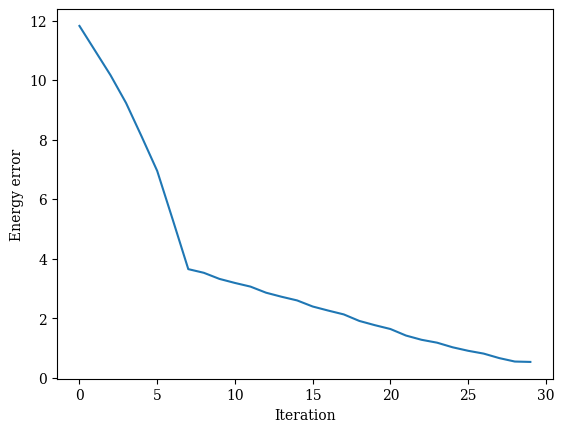

In [10]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [11]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [12]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [13]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

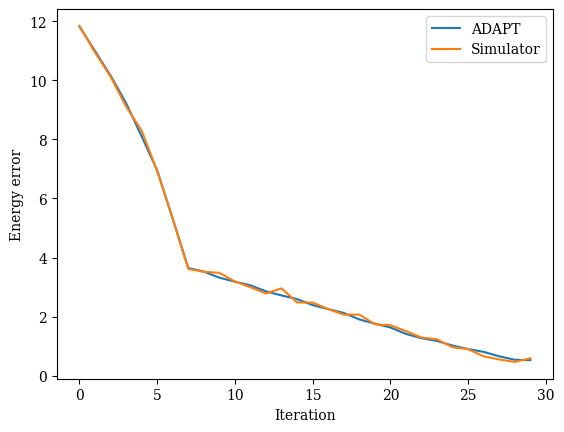

In [14]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [37]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [38]:
num_shots = 30_000
sampler = Sampler(sim)

In [42]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sim.run(to_run)
    # counts = job.result().data()['counts']
    # bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    # counts1 = bit_array.get_counts()
    job = sampler.run((circuit,), shots=num_shots)
    data = job.result()[0].data
    bit_array = data['meas']
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'x': 7, 'cx': 4, 'rx': 2, 'h': 2, 'barrier': 2, 'rz': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'cx': 8, 'x': 7, 'rx': 4, 'h': 4, 'barrier': 3, 'rz': 2})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'cx': 12, 'x': 7, 'rx': 6, 'h': 6, 'barrier': 4, 'rz': 3})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 16, 'measure': 16, 'rx': 8, 'h': 8, 'x': 7, 'barrier': 5, 'rz': 4})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 22, 'measure': 16, 'rx': 10, 'h': 10, 'x': 7, 'barrier': 6, 'rz': 5})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 28, 'measure': 16, 'rx': 12, 'h': 12, 'x': 7, 'barrier': 7, 'rz': 6})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 30, 'measure': 16, 'rx': 14, 'h': 14, 'barrier': 8, 'x': 7, 'rz': 7})
On circuit 7/30
Gate counts (w/ pre-i

In [44]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

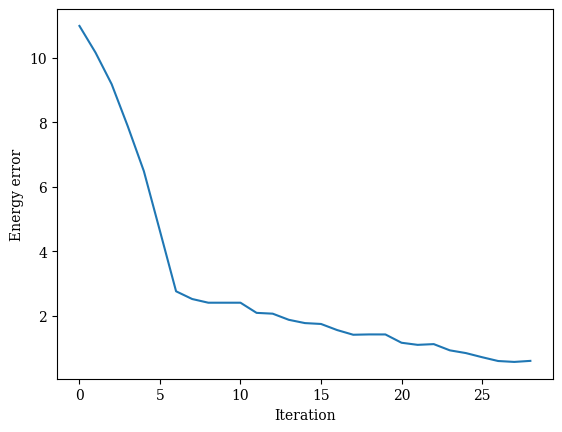

In [45]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [46]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

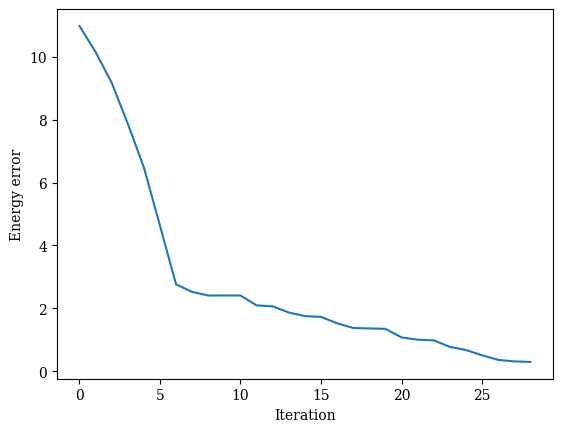

In [47]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

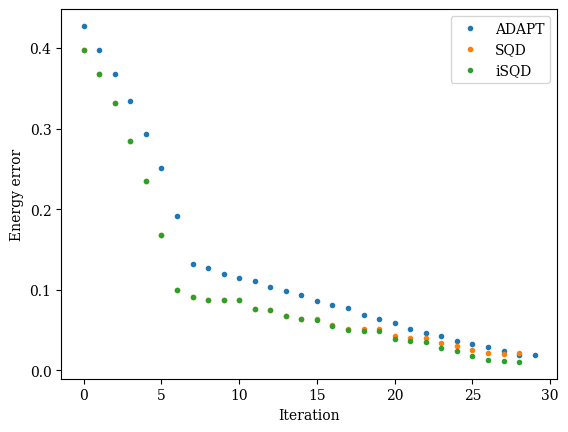

In [48]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()